In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
train_dir = '/Users/chaitrabhat/Final_project/dataset/train80'
test_dir = '/Users/chaitrabhat/Final_project/dataset/test20'
categories = ['Panama Disease','cordana','healthy','pestalotiopsis','sigatoka','xamthomonas']
img_size = (250, 250)
batch_size = 32
# ImageDataGenerators with EfficientNet preprocessing
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow from directory
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Compute class weights
class_labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))
# Load EfficientNetB0 model
base_model = EfficientNetB0(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Optional: freeze some layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(len(categories), activation='softmax')
])
# Compile model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Train model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=25,
    callbacks=[early_stopping],
    class_weight=class_weights
)


Found 4800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/Users/chaitrabhat/Banana_Project/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 76s 483ms/step - accuracy: 0.4233 - loss: 3.7444
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 583ms/step - accuracy: 0.8566 - loss: 2.4758
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 93s 616ms/step - accuracy: 0.9115 - loss: 1.9910
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 556ms/step - accuracy: 0.9389 - loss: 1.6555
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 90s 598ms/step - accuracy: 0.9517 - loss: 1.3924
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 582ms/step - accuracy: 0.9592 - loss: 1.1563
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - accuracy: 0.9598 - loss: 0.9718
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 720ms/step - accuracy: 0.9571 - loss: 0.8088
Epoch 9/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 527ms/step - accuracy: 0.9660 - loss: 0.6678
Epoch 10/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 591ms/step - accuracy: 0.9685 - loss: 0.5613
Epoch 11/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 92s 614ms/step - accuracy: 0.9746 - loss: 0.4727
Epoch 12/25
150/15

38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.9875 - loss: 0.0920



 Final Test Accuracy: 0.9775 | Test Loss: 0.1179
 Final Training Accuracy: 0.9869


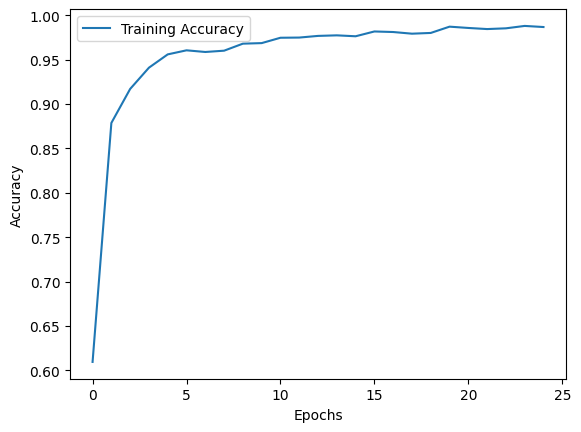

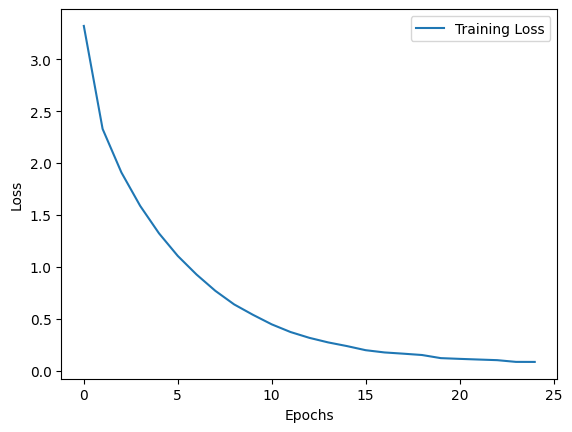


 Predicting test data for evaluation...
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step

Classification Report:
                precision    recall  f1-score   support

Panama Disease     0.9949    0.9850    0.9899       200
       cordana     1.0000    1.0000    1.0000       200
       healthy     0.9202    0.9800    0.9492       200
pestalotiopsis     0.9852    1.0000    0.9926       200
      sigatoka     0.9804    1.0000    0.9901       200
   xamthomonas     0.9890    0.9000    0.9424       200

      accuracy                         0.9775      1200
     macro avg     0.9783    0.9775    0.9774      1200
  weighted avg     0.9783    0.9775    0.9774      1200


 Confusion Matrix:


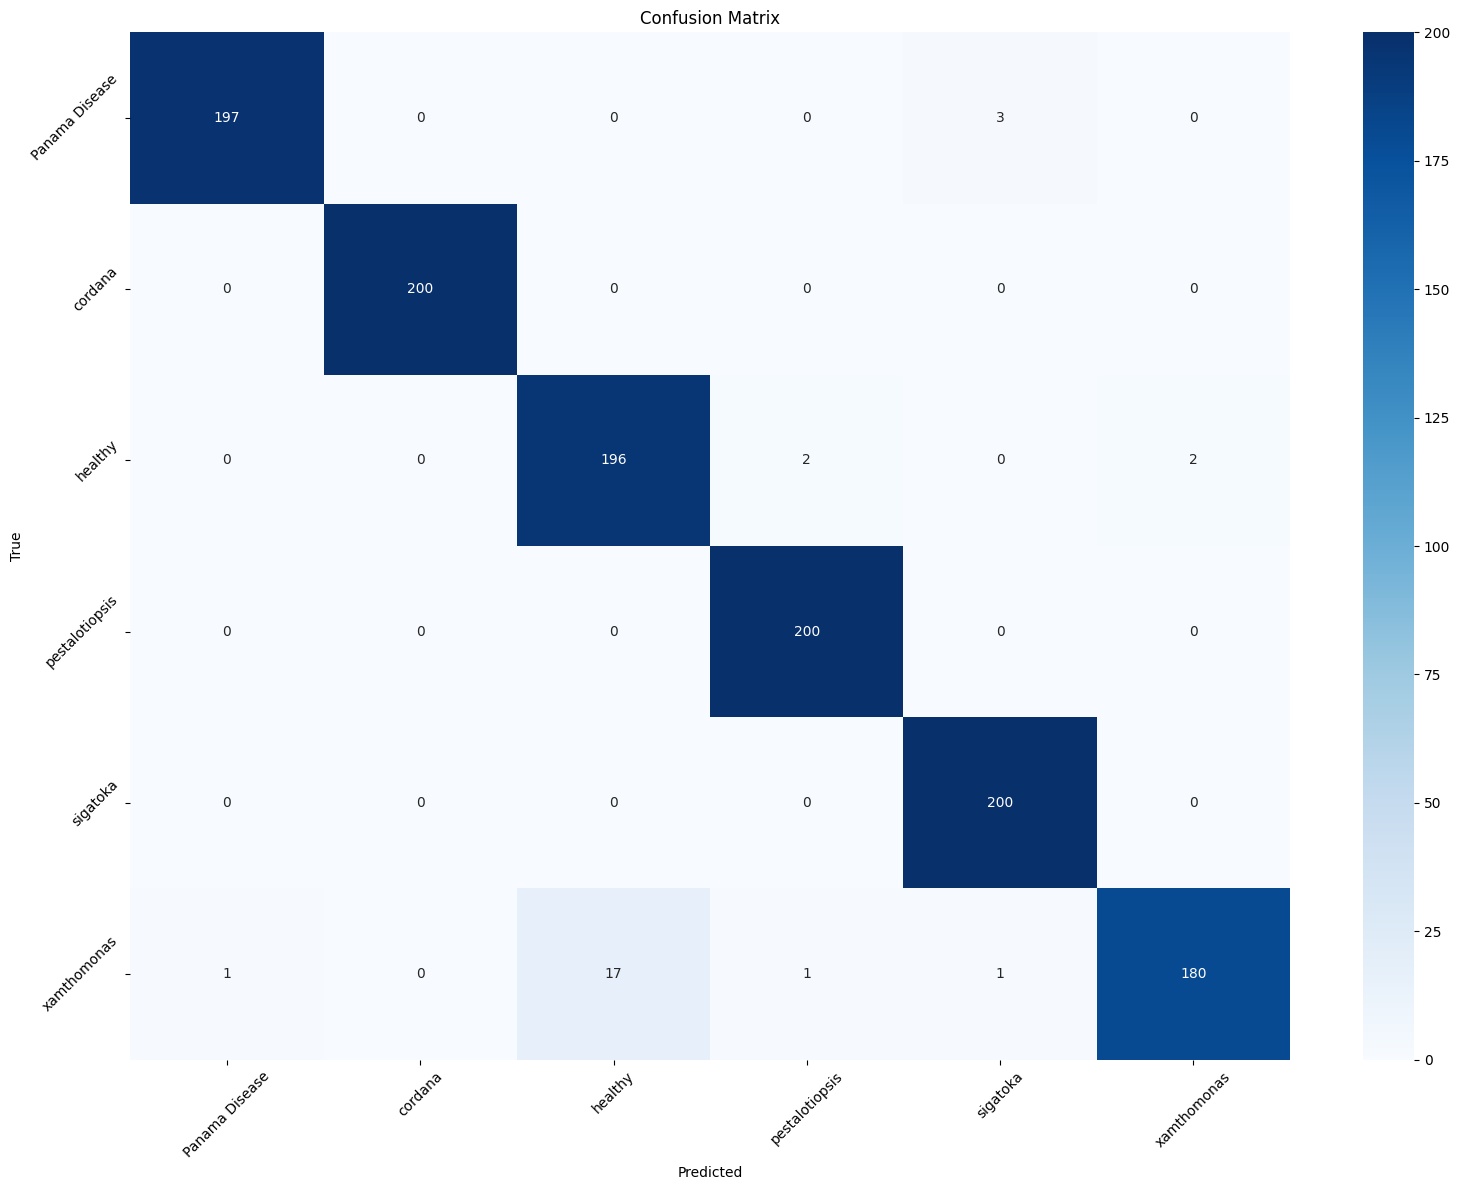

In [2]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"\n Final Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")
train_accuracy = history.history['accuracy'][-1]
print(f" Final Training Accuracy: {train_accuracy:.4f}")

# Save model
model.save('/Users/chaitrabhat/Final_project/models/EfficientNet_banana_classification_model80.h5')
# Plot accuracy & loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n Predicting test data for evaluation...")
y_true = test_data.classes
y_probs = model.predict(test_data)
y_pred = np.argmax(y_probs, axis=1)

print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=categories, digits=4)
print(report)

print("\n Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Prediction Function
def predict_image(image_path):
    from tensorflow.keras.utils import load_img, img_to_array
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    class_idx = tf.argmax(predictions[0]).numpy()
    return categories[class_idx]

# Test the prediction function
sample_image_path = '/Users/chaitrabhat/Final_project/dataset/test20/Panama Disease/0001.jpg'
print("Predicted Class:", predict_image(sample_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
Predicted Class: Panama Disease
